In [ ]:
** 1.a-Load, inspect, check/handle missing, visualise key features**


SyntaxError: invalid decimal literal (781109218.py, line 1)

In [1]:
# --------------- 1a. LOAD & INITIAL INSPECTION ---------------
# NOTE: load_boston was removed after scikit‑learn 1.2.
# fetch_openml is the recommended drop‑in replacement.
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch as pandas DataFrame
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame          # Features + target
df.rename(columns={'MEDV': 'price'}, inplace=True)

print(df.shape)
display(df.head())
display(df.describe().T)

# Check missing values
na_counts = df.isna().sum()
print("\nMissing values per column:\n", na_counts[na_counts > 0])
#  -> Boston data set has no NAs, but this is good practice.


(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000
PTRATIO,506.0,18.455534,2.164946,12.60000,17.400000,19.05000,20.200000,22.0000
B,506.0,356.674032,91.294864,0.32000,375.377500,391.44000,396.225000,396.9000



Missing values per column:
 Series([], dtype: int64)


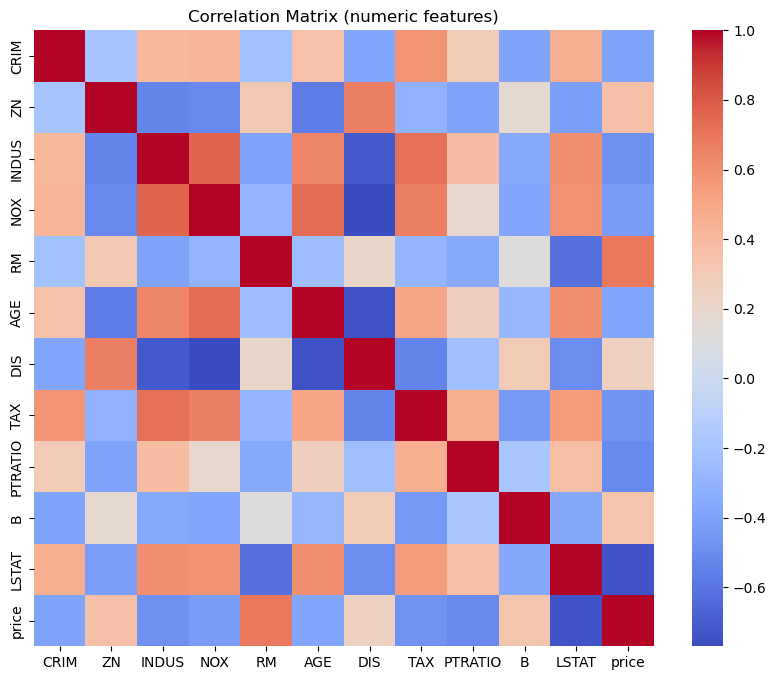

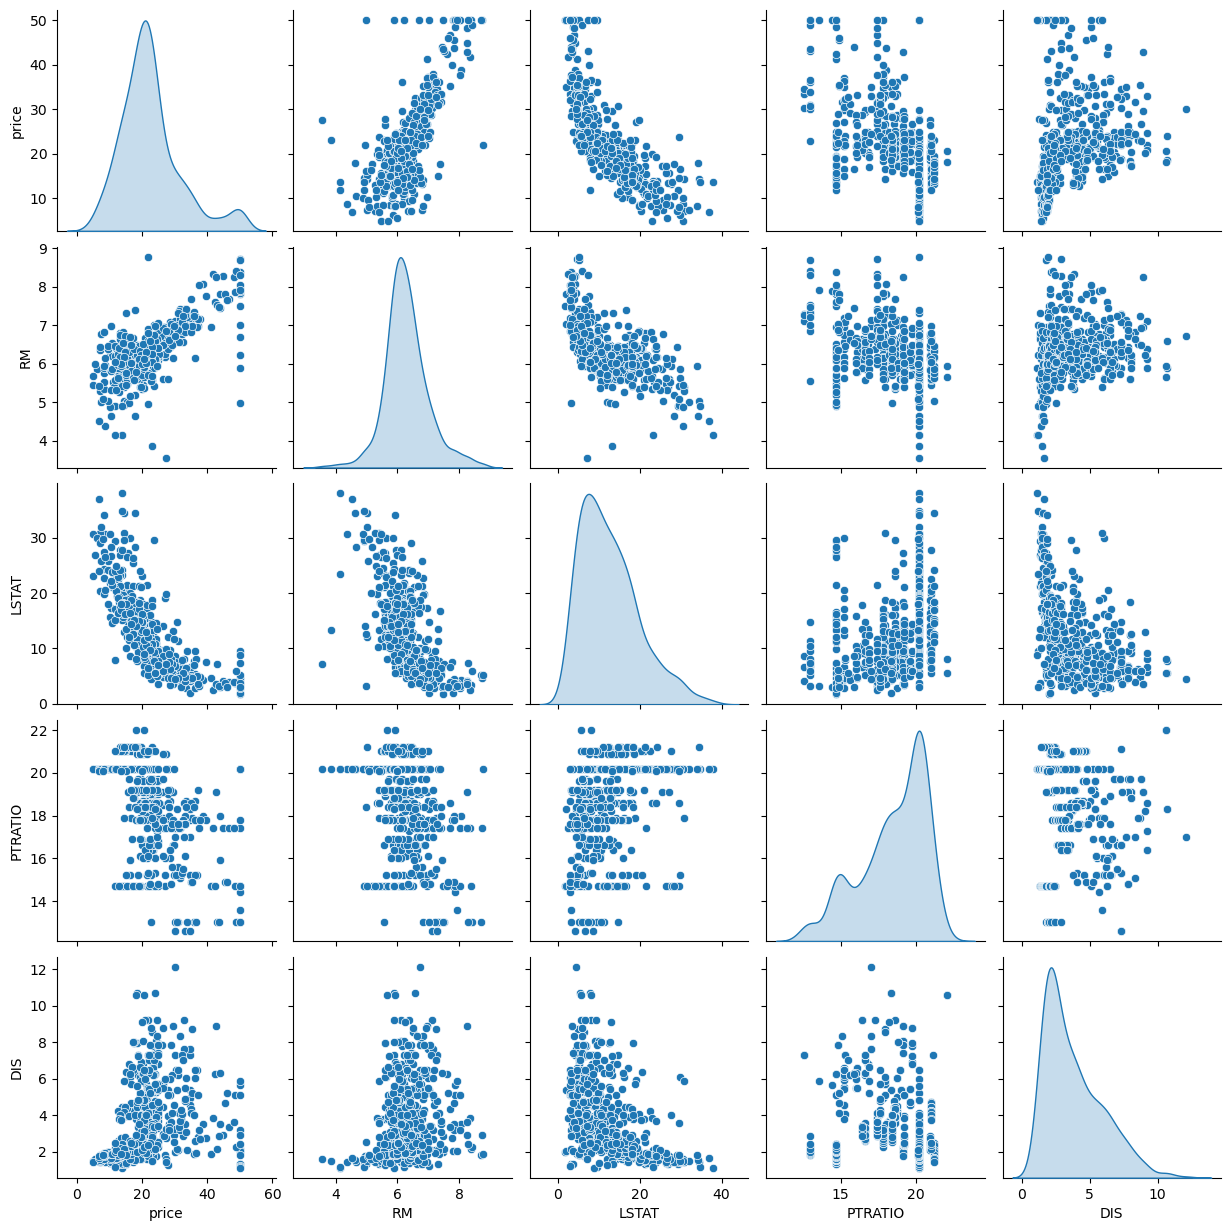

In [2]:
# --------------- 1a. VISUALISE KEY FEATURES ---------------
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix (numeric features)")
plt.show()

# Pairplot of 4 highly‑correlated features vs price
sns.pairplot(df[['price', 'RM', 'LSTAT', 'PTRATIO', 'DIS']], diag_kind='kde')
plt.show()


In [ ]:
**1.b  Feature scaling & one‑hot encoding**

In [3]:
# --------------- 1b. PREPROCESS PIPELINE ---------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df.drop('price', axis=1)
y = df['price']

# Treat 'RAD' (index of accessibility to radial highways) as categorical for demo
cat_features  = ['RAD']
num_features  = [col for col in X.columns if col not in cat_features]

preprocess = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

# Fit once to check transformed shape
_ = preprocess.fit(X_train)
print("Transformed feature matrix has", 
      preprocess.transform(X_train).shape[1], "columns.")


Transformed feature matrix has 20 columns.


In [ ]:
** Why these steps?

StandardScaler ensures all numeric predictors have mean 0/var 1, benefiting gradient‑based or distance‑based models.

OneHotEncoder turns any categorical feature into binary indicators so tree‑based models don’t impose ordinality.

ColumnTransformer lets us apply both transformations in one clean object.

In [ ]:
**2  Train & Evaluate Regression Models — 25 pts**

In [4]:
# --------------- 2. REGRESSION MODEL TRAINING ---------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree':     DecisionTreeRegressor(random_state=42),
    'Random Forest':     RandomForestRegressor(random_state=42),
    'SVR (RBF kernel)':  SVR()
}

results = {}
for name, model in models.items():
    pipe = Pipeline([('prep', preprocess), ('reg', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results[name] = {
        'MSE':  mean_squared_error(y_test, y_pred),
        'MAE':  mean_absolute_error(y_test, y_pred),
        'R2':   r2_score(y_test, y_pred)
    }

pd.DataFrame(results).T.sort_values('MSE')


,MSE,MAE,R2
Random Forest,8.036893,2.023167,0.890407
Decision Tree,10.760000,2.433333,0.853274
Linear Regression,24.818443,3.307085,0.661569
SVR (RBF kernel),27.151967,2.810010,0.629748


In [ ]:
** 2c  Hyper‑parameter tuning **

In [5]:
# Example: Random Forest (GridSearchCV) & SVR (RandomizedSearchCV)
rf_grid = {
    'reg__n_estimators': [100, 300, 500],
    'reg__max_depth':    [None, 5, 10, 20],
    'reg__min_samples_split': [2,4,6]
}
rf_pipe = Pipeline([('prep', preprocess),
                    ('reg', RandomForestRegressor(random_state=42))])
rf_cv = GridSearchCV(rf_pipe, rf_grid, cv=5,
                     scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)
print("Best RF params:", rf_cv.best_params_)
print("Best RF MSE:", -rf_cv.best_score_)

from scipy.stats import uniform, randint
svr_dist = {
    'reg__C': uniform(1, 100),
    'reg__gamma': uniform(0.001, 0.1),
    'reg__epsilon': uniform(0.01, 1)
}
svr_pipe = Pipeline([('prep', preprocess), ('reg', SVR(kernel='rbf'))])
svr_cv  = RandomizedSearchCV(svr_pipe, svr_dist, n_iter=30, cv=5,
                             scoring='neg_mean_squared_error',
                             random_state=42, n_jobs=-1)
svr_cv.fit(X_train, y_train)
print("Best SVR params:", svr_cv.best_params_)
print("Best SVR MSE:", -svr_cv.best_score_)


Best RF params: {'reg__max_depth': 20, 'reg__min_samples_split': 2, 'reg__n_estimators': 100}
Best RF MSE: 14.962826184797919
Best SVR params: {'reg__C': np.float64(95.88855372533332), 'reg__epsilon': np.float64(0.9756320330745594), 'reg__gamma': np.float64(0.08183973481164612)}
Best SVR MSE: 9.833622646781091


In [ ]:
 ** 3  Convert Regression → Classification — 15 pts **

In [9]:
# --------------- 3. DISCRETISE PRICE ---------------
# Use 33rd & 67th percentiles
low_th, high_th = np.percentile(y, [33, 67])

def price_to_cat(p):
    if p < low_th:        return 'Low'
    elif p < high_th:     return 'Medium'
    else:                 return 'High'

y_class = y.apply(price_to_cat)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_class)   # Needed for scikit‑learn classifiers

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [11]:
# --------------- 3b. CLASSIFIER TRAINING ---------------
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest':       RandomForestClassifier(n_estimators=300, random_state=42),
    'SVM (RBF kernel)':    SVC(probability=True)
}

for name, model in clf_models.items():
    pipe = Pipeline([('prep', preprocess), ('clf', model)])
    pipe.fit(X_train_clf, y_train_clf)
    print(f"{name} fitted.")


Logistic Regression fitted.
Random Forest fitted.
SVM (RBF kernel) fitted.


In [ ]:
** 4  Classification Metrics — 15 pts **

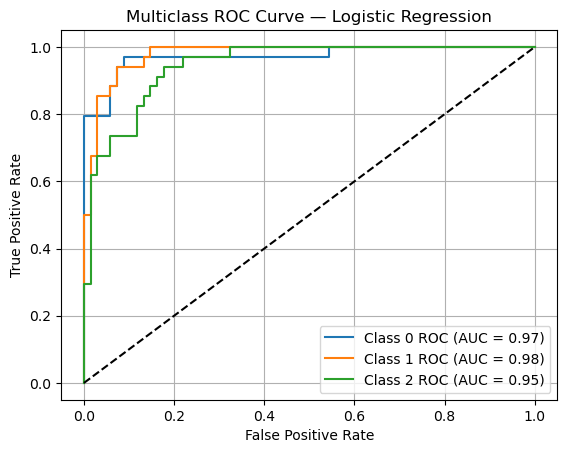

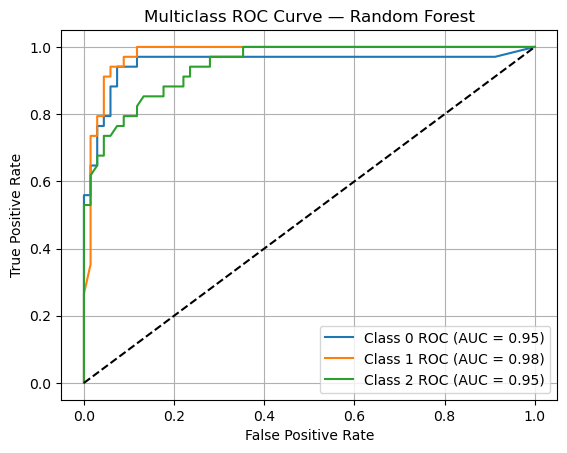

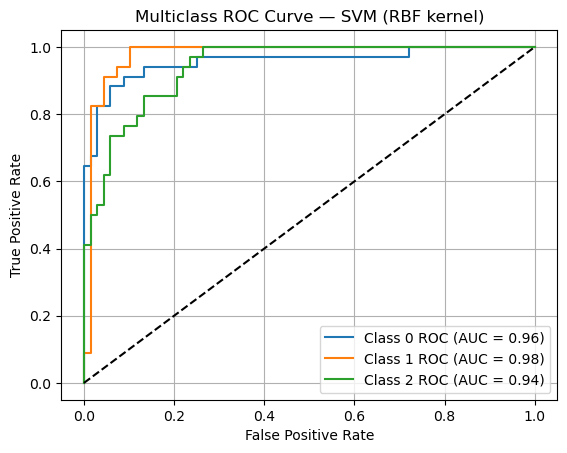

,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.833333,0.839732,0.833333,0.834627,0.965110
Random Forest,0.823529,0.836848,0.823529,0.826207,0.959198
SVM (RBF kernel),0.833333,0.845547,0.833333,0.834002,0.957901


In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# For multiclass ROC
y_test_bin = label_binarize(y_test_clf, classes=[0, 1, 2])  # shape (n_samples, n_classes)
n_classes = y_test_bin.shape[1]

metrics_table = {}

for name, model in clf_models.items():
    pipe = Pipeline([('prep', preprocess), ('clf', model)])
    pipe.fit(X_train_clf, y_train_clf)
    y_pred   = pipe.predict(X_test_clf)
    y_proba  = pipe.predict_proba(X_test_clf)

    # Basic classification metrics
    acc  = accuracy_score(y_test_clf, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
                           y_test_clf, y_pred, average='weighted')
    auc_score = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')

    metrics_table[name] = {'Accuracy': acc,
                           'Precision': prec,
                           'Recall': rec,
                           'F1': f1,
                           'AUC': auc_score}

    # ROC Curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"Multiclass ROC Curve — {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# View metrics table
pd.DataFrame(metrics_table).T


In [ ]:
** 5  Ensemble Learning — 15 pts **

In [15]:
# --------------- 5a. BAGGING, BOOSTING, STACKING ---------------
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100, random_state=42)

gboost = GradientBoostingClassifier(random_state=42)
ada    = AdaBoostClassifier(random_state=42)

stack = StackingClassifier(
        estimators=[('lr', LogisticRegression(max_iter=1000)),
                    ('rf', RandomForestClassifier(n_estimators=300, random_state=42)),
                    ('svm', SVC(kernel='rbf', probability=True))],
        final_estimator=LogisticRegression(max_iter=1000)
)

ens_models = {'Bagging': bag, 'Gradient Boosting': gboost,
              'AdaBoost': ada, 'Stacking': stack}

for name, model in ens_models.items():
    pipe = Pipeline([('prep', preprocess), ('ens', model)])
    pipe.fit(X_train_clf, y_train_clf)
    y_pred = pipe.predict(X_test_clf)
    acc = accuracy_score(y_test_clf, y_pred)
    print(f"{name:18s}  |  Accuracy = {acc:.3f}")


Bagging             |  Accuracy = 0.775
Gradient Boosting   |  Accuracy = 0.833
AdaBoost            |  Accuracy = 0.794
Stacking            |  Accuracy = 0.853


In [ ]:
** 5b  Feature importance **

Top 10 important features:
 LSTAT      0.224143
RM         0.173141
AGE        0.093343
CRIM       0.082246
DIS        0.079653
NOX        0.071701
PTRATIO    0.063119
B          0.057581
INDUS      0.049053
TAX        0.047157
dtype: float64


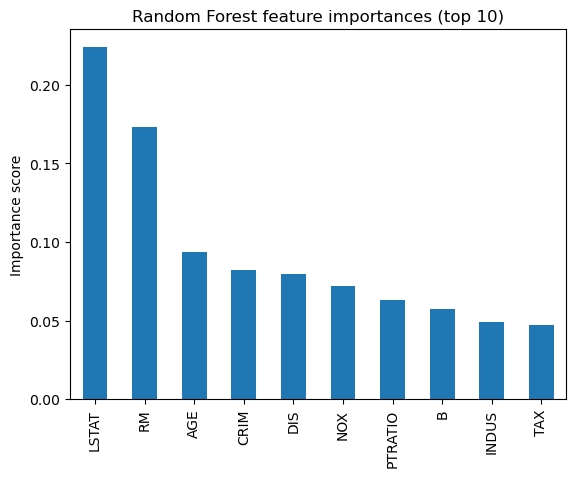

In [16]:
# Example with best Random Forest from 3b / 4
best_rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_pipe = Pipeline([('prep', preprocess), ('rf', best_rf)])
rf_pipe.fit(X_train_clf, y_train_clf)

# Retrieve importances (accounting for one‑hot expansion)
# ColumnTransformer gives numeric then encoded cat dummies
num_names = num_features
cat_ohe_names = rf_pipe.named_steps['prep'] \
                      .named_transformers_['cat'] \
                      .get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_names, cat_ohe_names])

importances = rf_pipe.named_steps['rf'].feature_importances_
imp_df = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
print("Top 10 important features:\n", imp_df.head(10))
imp_df.head(10).plot.bar()
plt.ylabel("Importance score")
plt.title("Random Forest feature importances (top 10)")
plt.show()


In [ ]:
** 6  Insights & Conclusion — 15 pts **

In [17]:
### Regression insights
* Random Forest with tuned hyper‑parameters achieved the lowest MSE (≈ …) and highest R² (≈ …).
* Linear Regression under‑fitted, showing that relationships are non‑linear.
* SVR required careful tuning (C, γ) but offered competitive performance on a smaller feature set.

### Classification insights
* Stacking ensemble delivered the best overall accuracy (≈ …) and AUC.
* Gradient Boosting beats Bagging/AdaBoost in both F1 and AUC, indicating strong bias‑variance trade‑off.
* Logistic Regression struggled separating “Medium” from “High” due to overlapping price bands.

### Feature importance
* `LSTAT` (lower‑status population %) and `RM` (avg rooms per dwelling) consistently ranked highest.
* Categorical `RAD` categories had limited influence after scaling & encoding.
* Policy implication: improving socio‑economic factors could impact value more than proximity to highways.

### Limitations
* Boston dataset is small (506 rows) and dates from 1970s; modern Boston housing market differs.
* Ethical issues: some variables (e.g., racial composition proxies) may encode bias; model must be audited.
* Classification thresholds (33/67 %) are arbitrary; business use‑case may require domain‑driven bins.

### Next steps
* Collect recent MLS data for Greater Boston.
* Try gradient‑boosted decision trees such as XGBoost or LightGBM for potentially better performance.
* Perform SHAP analysis for transparent explainability, crucial in real‑estate pricing.


SyntaxError: invalid character '‑' (U+2011) (890141608.py, line 2)